# COVID-19 ERTEs Impact Visualization in Barcelona

## Introduction

Due to the Coronavirus disease (COVID-19) outbreak situation that the world has been suffering for the last months, on March 14, 2020, <cite>[the Spanish government declared the so-called _Estado de Alarma_][1]</cite>, imposing restrictions on the mobility of the population and the economic activity of different sectors, in order to control the spread of the virus across the country. 

These measures have had, unfortunately, a big impact on the economy and employment. Companies and employers are losing <cite>[thousands of millions of Euros][2]</cite> and, as a consequence, many of them have had to drastically reduce their number of employees via a procedure called <cite>[_Expediente de Regulación Temporal de Empleo_][3]</cite>, or _ERTE_ for short, which allows companies and business to temporarily fire one or more employees, during the time their economic activity is suspended.

We are interested in visualizing the impact of such ERTEs from a geographical point of view in the Spanish city of _Barcelona_, which is one of the most important ones from an economic point of view. This information could be useful for city governments or civil servants in order to have a clearer idea of the areas in the city that are suffering bigger economic consequences from the pandemic.

In particular, we want to examine and classify the different types of venues, shops and services of each of the neighborhoods of the city, and use data of the ERTEs in Catalonia in order to cluster neighborhoods in terms of the impact these ERTEs have had on each of them. After all the analysis, we want to produce a map of Barcelona that allows visualizing the results.  

We are going to use several data sources for this. First of all, we need a list of all the neighborhoods that we are examining. There is a Wikipedia page for that. Also, we are going to use the Foursquare API to obtain venues and services, as well as information about them, in each neighborhood. Finally, we are using three datasets from the webpage <cite>[_Dades Obertes Catalunya_][4]</cite> that contain information on the number of ERTEs per economic sector, per county, and per day, which will allow us to infer the effect of those ERTEs on each neighborhood. 

[1]: https://www.boe.es/diario_boe/txt.php?id=BOE-A-2020-3692
[2]: https://www.abc.es/economia/abci-economia-tras-covid-19-hundimientos-y-empleo-rapida-recuperacion-y-cambios-consumo-202004070159_noticia.html
[3]: https://www.lavanguardia.com/economia/20200320/474272215730/erte-empleo-paro-derechos-trabajador-que-es-cobrar-seguridad-social.html
[4]: https://analisi.transparenciacatalunya.cat/browse?q=erto&sortBy=relevance&utf8=%E2%9C%93

### Import all required packages

In [2]:
import numpy as np 
import pandas as pd 
import json # library to handle JSON files

pd.set_option("display.max_rows", None, "display.max_columns", None)


import geocoder 
from geopy.geocoders import Nominatim 
import pgeocode

import requests # library to handle http methods
from datetime import datetime

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

from bs4 import BeautifulSoup #to parse data from webpages

## Initial analysis

We start by importing the dataframe containing the number of ERTEs per economic sector.

In [2]:
erte_es_df = json_normalize(requests.get('https://analisi.transparenciacatalunya.cat/resource/hu7t-2x76.json').json())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """Entry point for launching an IPython kernel.


In [3]:
erte_es_df.head()

,codi_divisi_econ_mica,divisi_econ_mica_ccae_2009,causa,n_mero_d_expedients,n_mero_d_afectats
0,01,"Agricultura, ramaderia i caça",Força major,391,2400
1,02,Silvicultura i explotació forestal,Força major,39,436
2,03,Pesca i aqüicultura,Força major,215,921
3,05,"Antracita, hulla i lignit",Força major,67,640
4,06,Petroli i gas natural,Força major,26,129


In [4]:
erte_es_df.shape

(178, 5)

As we can see, this dataframe contains 178 rows and 5 columns. The columns contain the following information:
- <b>codi_divisi_econ_mica</b>: unique numberic value that identifies an especific economic sector. 
- <b>divisi_econ_mica_ccae_2009</b>: economic sector.
- <b>causa</b>: why the ERTEs on that economic sector occured. 
- <b>n_mero_d_expedients</b>: number of ERTEs for a particular economic sector and cause.
- <b>n_mero_d_afectats</b>: number of people affected (since each ERTE can affect one or more employees). 

Let us first see what are the different causes of an ERTE that appear on this dataframe.

In [5]:
erte_es_df['causa'].unique()

array(['Força major', 'Altres causes'], dtype=object)

Apparently, there are only two causes: _Força major_ (Force majeure) and _Altres causes_ (Other reasons). Since this does not give much information, we are going to delete this column. 

In [6]:
erte_es_df.drop(['causa'], axis = 1, inplace=True)

In [7]:
erte_es_df['divisi_econ_mica_ccae_2009'].value_counts()

Activitats auxiliars mediació financera    2
Arts gràfiques i suports enregistrats      2
Transport aeri                             2
Mobles                                     2
Llars que ocupen personal domèstic         2
                                          ..
Indústries de productes alimentaris        2
Publicitat i estudis de mercat             2
Organismes extraterritorials               2
Adm. pública, Defensa i SS obligatòria     2
Serveis d'informació                       2
Name: divisi_econ_mica_ccae_2009, Length: 89, dtype: int64

Each economic sector appears twice, probably since it appeared duplicated because of the two possible causes of an ERTE.

In [8]:
erte_es_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   codi_divisi_econ_mica       178 non-null    object
 1   divisi_econ_mica_ccae_2009  178 non-null    object
 2   n_mero_d_expedients         178 non-null    object
 3   n_mero_d_afectats           178 non-null    object
dtypes: object(4)
memory usage: 5.7+ KB


Also, notice that datatypes need to be fixed, and there are som null values. Let us fix rename the columns for convenience, and let us fix the null values and the  datatypes. 

In [9]:
erte_es_df.rename(columns = {'codi_divisi_econ_mica': 'Code', 'divisi_econ_mica_ccae_2009':'Economic sector', 
                             'n_mero_d_expedients':'Number of ERTEs', 
                             'n_mero_d_afectats':'Number of people'}, inplace = True)

In [10]:
erte_es_df.dropna(axis = 0, inplace = True)

In [11]:
erte_es_df[['Number of ERTEs', 'Number of people']] = erte_es_df[['Number of ERTEs', 'Number of people']].astype(int)

In [12]:
erte_es_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178 entries, 0 to 177
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Code              178 non-null    object
 1   Economic sector   178 non-null    object
 2   Number of ERTEs   178 non-null    int64 
 3   Number of people  178 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 7.0+ KB


Now we can group the values by economic sectors.

In [13]:
erte_es_grouped = erte_es_df.groupby(['Code','Economic sector'], as_index = False).sum()

Now, let us sort sectors from the one with the most number of ERTEs to the one with the least. 

In [14]:
erte_es_grouped.sort_values(['Number of ERTEs'], ascending = False, inplace = True)

In [15]:
erte_es_grouped.head()

,Code,Economic sector,Number of ERTEs,Number of people
50,56,Serveis de menjar i begudes,18607,106971
43,47,"Comerç detall, exc. vehicles motor",12151,53889
85,96,Altres activitats de serveis personals,6715,18128
42,46,"Comerç engròs, exc. vehicles motor",5174,44592
40,43,Activitats especialitzades construcció,4758,26976


In [16]:
erte_es_grouped.sum()

Code                564796464386458593554149682569-811852821071949...
Economic sector     Serveis de menjar i begudesComerç detall, exc....
Number of ERTEs                                                 90815
Number of people                                               668104
dtype: object

There has been, in total, 90815 ERTEs in Catalonia, affecting 668104 employees. The top 5 sectors with the highest number of ERTEs are:
- Food and drinks, such as bars, restaurants, coffee shops,...
- Shops of any kind, supermarkets,... (except motor vehicles).
- Personal services, such as beauty saloons, laundries, or funeral services. 
- Wholesaling (except motor vehicles).
- Construction related activities.

In [17]:
erte_es_grouped.sort_values(['Number of people'], ascending = False).head()

,Code,Economic sector,Number of ERTEs,Number of people
50,56,Serveis de menjar i begudes,18607,106971
43,47,"Comerç detall, exc. vehicles motor",12151,53889
42,46,"Comerç engròs, exc. vehicles motor",5174,44592
75,85,Educació,3424,34647
28,29,"Vehicles de motor, remolcs i semiremolcs",169,31890


On the other hand, the top 5 sectors with the highest number of people affected by ERTEs are:
- Food and drinks.
- Shops.
- Wholesaling.
- Education.
- Motor vehicles and trailers. 

Notice that there is a discrepancy between the most affected sectors by number of ERTEs and the most affected sectors by people affected on them. Remember that we are examining this data because we want to use it in order to associate some sort of impact measure of ERTEs on each neighbourhood of Barcelona. Thus, we believe that it is more reasonable to use the number of ERTEs as a preliminary feature for measuring such impact rather than the number of people affected. Let us drop the last column.

In [18]:
erte_es_grouped.drop(['Number of people'], axis = 1, inplace = True)

Let us visualize the top 10 sectors again by number of ERTEs.

/home/alejandro/.local/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


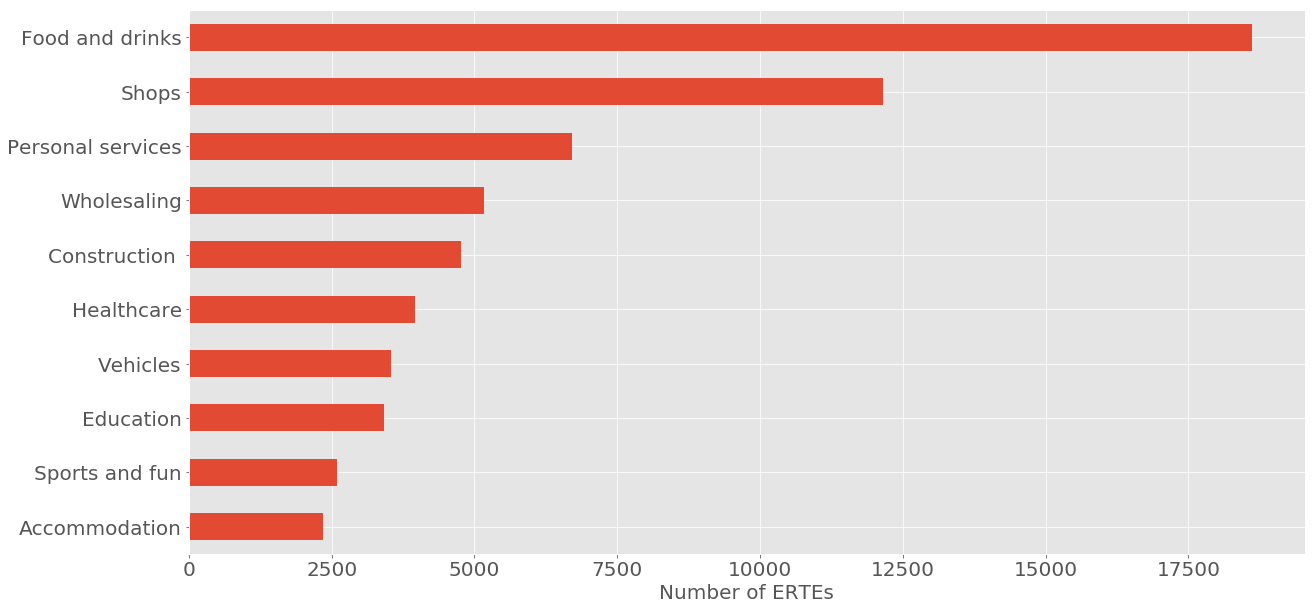

In [204]:
top_15 = erte_es_grouped.head(10)
top_15.loc[:,'Economic sector'] = ['Food and drinks', 
                                 'Shops', 
                                 'Personal services', 
                                 'Wholesaling', 
                                 'Construction ', 
                                 'Healthcare', 
                                 'Vehicles', 
                                 'Education', 
                                 'Sports and fun', 
                                 'Accommodation']
top_15.set_index('Economic sector', inplace = True)
top_15.head()

fig, ax = plt.subplots(figsize = (20,10))
ax.set_xlabel('Number of ERTEs', fontsize = 20)


top_15.plot(kind='barh', figsize = (20,10), fontsize = 20, ax = ax)
ax.set_ylabel('')
ax.get_legend().remove()

ax.invert_yaxis()

Now, let us take a look very quickly at the data of ERTEs per day.

In [5]:
erte_time_df = json_normalize(requests.get('https://analisi.transparenciacatalunya.cat/resource/atmi-6snp.json').json())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """Entry point for launching an IPython kernel.


In [6]:
erte_time_df.head()

,causa,data,n_mero_d_expedients,n_mero_d_afectats
0,Força major,2020-03-23T00:00:00.000,2.352,15.901
1,Força major,2020-03-24T00:00:00.000,4.402,25.067
2,Força major,2020-03-25T00:00:00.000,10.564,68.170
3,Força major,2020-03-26T00:00:00.000,9.511,59.460
4,Força major,2020-03-27T00:00:00.000,7.217,46.161


In [21]:
erte_time_df.loc[:,['n_mero_d_expedients', 'n_mero_d_afectats']] = erte_time_df.loc[:,['n_mero_d_expedients', 'n_mero_d_afectats']].applymap(lambda x: x.replace('.','')).astype(int)
erte_time_df.loc[:, 'data'] = erte_time_df.loc[:, 'data'].apply(lambda x: datetime.strptime(x,'%Y-%m-%dT%H:%M:%S.%f'))
erte_time_df.rename(columns = {'data': 'Date','n_mero_d_expedients':'Number of ERTEs'}, inplace = True)
erte_time_df.drop(['causa','n_mero_d_afectats'], axis = 1, inplace = True)
erte_time_grouped = erte_time_df.groupby('Date').sum()

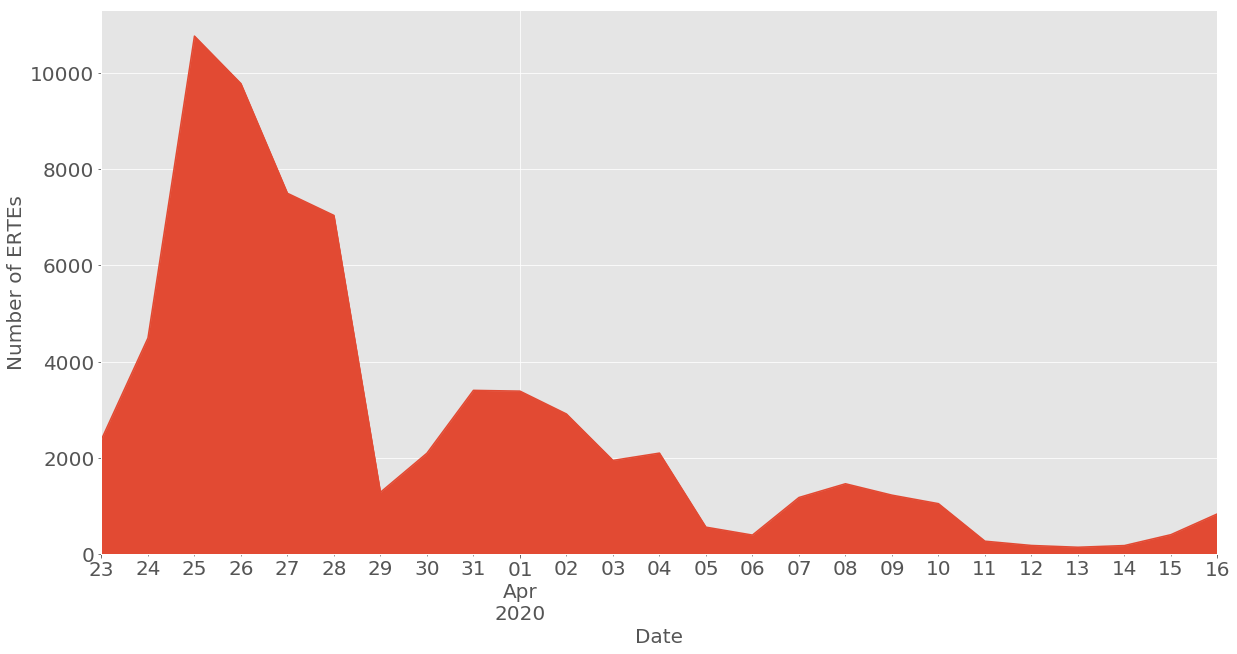

In [162]:
fig, ax = plt.subplots(figsize = (20,10))
ax.set_xlabel('Date', fontsize = 20)
ax.set_ylabel('Number of ERTEs', fontsize = 20)
erte_time_grouped.plot(kind = 'area', fontsize = 20, ax = ax)
ax.get_legend().remove()

In order to associate to each sector a measure of impact of the ERTEs, it might be reasonable to consider the quotient between the number of ERTEs and the number of companies and business in each sector. It is true that a certain company might have suffered more than one ERTE, but the data of the number of ERTEs per day suggests that the big majority of them occured during the first week of the quarentine, and since it is unlikely that a company suffered two or more ERTEs on the same week (otherwise, they would have done them at once), we might think that the rest of ERTEs correspond to a minority of companies and business that either decided to wait a bit longer before doing one ERTE, or decided to do another one given the circumstances. In any case, as we are saying, this is not a big number of cases, so it is reasonable to think that each ERTE coresponds, in general, to one business or company, and thus, by computing the quotient between ERTEs and companies on each sector, we are basically computing an estimated probability that a company of a certain sector suffered an ERTE. 

Let us then get the information of the total number of companies per sector in Catalonia. We can get the numbers from <cite>[this page][1]</cite>.

[1]: https://www.ine.es/jaxiT3/Tabla.htm?t=298&L=0

In [7]:
companies_sector_df = pd.read_csv('298bsc.csv', sep = '\t', encoding = 'latin-1', thousands = '.')
companies_sector_df.head(5)

,Comunidades y Ciudades Autónomas,Actividad principal,Estrato de asalariados,Periodo,Total
0,09 Cataluña,433 Acabado de edificios,Total,2019,13645
1,09 Cataluña,133 Acabado de textiles,Total,2019,327
2,09 Cataluña,82 Actividades administrativas de oficina y ot...,Total,2019,23657
3,09 Cataluña,821 Actividades administrativas y auxiliares d...,Total,2019,2112
4,09 Cataluña,522 Actividades anexas al transporte,Total,2019,3153


Let us drop the first, third and fourth columns.

In [24]:
companies_sector_df.drop(['Comunidades y Ciudades Autónomas', 'Estrato de asalariados', 'Periodo'], axis = 1, inplace = True)

In [25]:
companies_sector_df.shape

(333, 2)

We observe that there appear more economic sectors (333) than in the previous dataframe (88). This is because each economic sector of the dataframe erte_es_grouped can be further divided into subsectors, which appear in this second one. Let us first separate codes from names.

In [26]:
def get_code(string):
    return string[0:string.find(' ')]

def get_name(string):
    return string[string.find(' '):]

In [27]:
companies_sector_df['Código'] = companies_sector_df['Actividad principal'].apply(get_code)
companies_sector_df['Actividad principal'] = companies_sector_df['Actividad principal'].apply(get_name)

In [28]:
companies_sector_df.head()

,Actividad principal,Total,Código
0,Acabado de edificios,13645,433
1,Acabado de textiles,327,133
2,Actividades administrativas de oficina y otra...,23657,82
3,Actividades administrativas y auxiliares de o...,2112,821
4,Actividades anexas al transporte,3153,522


Now, we can just keep in this dataframe the rows corresponding to a code that appears in erte_es_grouped. 

In [29]:
companies_sector_cleaned = companies_sector_df[companies_sector_df['Código'].isin(erte_es_grouped['Code'])]
companies_sector_cleaned.head()

,Actividad principal,Total,Código
2,Actividades administrativas de oficina y otra...,23657,82
5,Actividades asociativas,8674,94
7,Actividades auxiliares a los servicios financ...,12118,66
11,"Actividades cinematográficas, de vídeo y de p...",1687,59
13,"Actividades de agencias de viajes, operadores...",2651,79


Unfortunately, in this last dataframe, there are 8 less sectors than in the first one. These are the following.

In [30]:
erte_es_grouped[~erte_es_grouped['Code'].isin(companies_sector_cleaned['Código'])]

,Code,Economic sector,Number of ERTEs
0,-,Sense especificar,1088
1,01,"Agricultura, ramaderia i caça",401
3,03,Pesca i aqüicultura,220
86,97,Llars que ocupen personal domèstic,166
74,84,"Adm. pública, Defensa i SS obligatòria",100
2,02,Silvicultura i explotació forestal,41
88,99,Organismes extraterritorials,21
87,98,Llars que prod. béns i serveis ús propi,6


We have no other option but to remove them from the erte_es_grouped dataframe. In any case, they represent sectors where the number of ERTEs are not really that high. 

In [31]:
erte_es_grouped.drop(erte_es_grouped[~erte_es_grouped['Code'].isin(companies_sector_cleaned['Código'])].index,axis = 0,inplace = True)

In [32]:
erte_es_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81 entries, 50 to 11
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Code             81 non-null     object
 1   Economic sector  81 non-null     object
 2   Number of ERTEs  81 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 2.5+ KB


In [33]:
companies_sector_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81 entries, 2 to 331
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Actividad principal  81 non-null     object
 1   Total                81 non-null     int64 
 2   Código               81 non-null     object
dtypes: int64(1), object(2)
memory usage: 2.5+ KB


Now we are sure that on each dataframe, the same sectors appear. 

In [34]:
erte_es_grouped.sort_values(['Number of ERTEs'], ascending = False, inplace = True)
companies_sector_cleaned.sort_values(['Total'], ascending = False, inplace = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [35]:
erte_es_grouped.head(10)

,Code,Economic sector,Number of ERTEs
50,56,Serveis de menjar i begudes,18607
43,47,"Comerç detall, exc. vehicles motor",12151
85,96,Altres activitats de serveis personals,6715
42,46,"Comerç engròs, exc. vehicles motor",5174
40,43,Activitats especialitzades construcció,4758
76,86,Activitats sanitàries,3964
41,45,Venda i reparació de vehicles motor,3537
75,85,Educació,3424
82,93,Activitats esportives i d'entreteniment,2595
49,55,Serveis d'allotjament,2354


In [36]:
companies_sector_cleaned.head(10)

,Actividad principal,Total,Código
101,"Comercio al por menor, excepto de vehículos d...",70037,47
55,Actividades inmobiliarias,45156,68
90,Comercio al por mayor e intermediarios del co...,43111,46
109,Construcción de edificios,41533,41
301,Servicios de comidas y bebidas,39586,56
21,Actividades de construcción especializada,32965,43
64,Actividades sanitarias,32280,86
326,Transporte terrestre y por tubería,31911,49
58,Actividades jurídicas y de contabilidad,25819,69
2,Actividades administrativas de oficina y otra...,23657,82


Let us stop here for a moment. It is time we examine the information on the number of ERTEs per county. 

In [37]:
erte_county_df = json_normalize(requests.get('https://analisi.transparenciacatalunya.cat/resource/6fpi-ycak.json').json())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """Entry point for launching an IPython kernel.


In [38]:
erte_county_df.head()

,causa,codi_comarca,comarca,n_mero_d_expedients,n_mero_d_afectats
0,Força major,01,Alt Camp,433,3250
1,Força major,02,Alt Empordà,2246,12162
2,Força major,03,Alt Penedès,1140,7467
3,Força major,04,Alt Urgell,291,1406
4,Força major,05,Alta Ribagorça,60,168


In [39]:
erte_county_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   causa                84 non-null     object
 1   codi_comarca         84 non-null     object
 2   comarca              84 non-null     object
 3   n_mero_d_expedients  84 non-null     object
 4   n_mero_d_afectats    84 non-null     object
dtypes: object(5)
memory usage: 3.4+ KB


Let us do some clean up again first.

In [40]:
erte_county_df.drop(['causa', 'codi_comarca'], axis = 1, inplace = True)

In [41]:
erte_county_df[erte_county_df['n_mero_d_expedients'].isna()]

,comarca,n_mero_d_expedients,n_mero_d_afectats


In [42]:
erte_county_df.rename({'comarca':'county', 'n_mero_d_expedients':'Number of ERTEs', 'n_mero_d_afectats':'Number of people'}, axis = 1, inplace = True)

In [43]:
erte_county_df[['Number of ERTEs', 'Number of people']] = erte_county_df[['Number of ERTEs', 'Number of people']].astype(int)

In [44]:
erte_county_grouped = erte_county_df.groupby(['county']).sum()
erte_county_grouped.sort_values(['Number of ERTEs'], ascending = False, inplace = True)

In [45]:
erte_county_grouped.head()

,Number of ERTEs,Number of people
county,,
Barcelonès,29848,227244
Vallès Occidental,9655,85068
Baix Llobregat,8537,90615
Maresme,4875,29396
Vallès Oriental,4359,31872


In [46]:
erte_county_grouped.sort_values(['Number of people'], ascending = False).head()

,Number of ERTEs,Number of people
county,,
Barcelonès,29848,227244
Baix Llobregat,8537,90615
Vallès Occidental,9655,85068
Vallès Oriental,4359,31872
Maresme,4875,29396


Again, there is some discrepancy when ordering counties by number of ERTEs or by number of people affected. Nevertheless, following what we did before, let us drop the column of the number of people affected. Also, let us look at the proportions.

In [47]:
erte_county_grouped.drop(['Number of people'],axis = 1, inplace = True)
erte_county_grouped['Proportion of ERTEs'] = erte_county_grouped['Number of ERTEs']/(erte_county_grouped['Number of ERTEs'].sum())
erte_county_grouped.drop(['Number of ERTEs'], axis = 1, inplace = True)

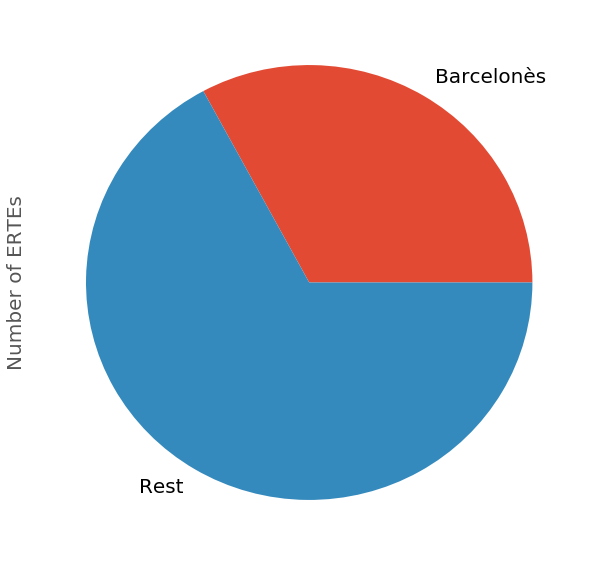

In [320]:
fig, ax = plt.subplots(figsize = (10,10))
ax.set_ylabel('Number of ERTEs', fontsize = 20)

pd.DataFrame(index = ['Barcelonès', 'Rest'], 
             columns = ['Number of ERTEs'], 
             data = [erte_county_grouped.loc['Barcelonès',].values[0], erte_county_grouped.loc['Vallès Occidental':,].sum().values[0]]).plot(kind = 'pie', subplots = True, ax = ax, fontsize = 20)

ax.get_legend().remove()

As we can see, almost 1/3 of all the ERTEs ocurred in Barcelonès, which is the county where Barcelona belongs to. Being Barcelona the biggest city of that county, we will make the following simplification: we will asume that, for each economic sector, the proportion of companies that suffered and ERTE in Barcelona is the same as the proportion in Catalonia (which is the information we can get from the other datasets).

We stop here again. It is time to make a list of all the neighborhoods in Barcelona, and look at location data of each neighborhood to get the venues, shops and services in them.

### Location Data

#### Neighborhoods in Barcelona

In [3]:
url = 'https://ca.wikipedia.org/wiki/Categoria:Barris_de_Barcelona'
wiki = requests.get(url).text

soup_bcn = BeautifulSoup(wiki, 'html.parser')
table_bcn = soup_bcn.find('table',{'class': 'nowraplinks collapsible autocollapse navbox-inner'})

In [4]:
neigh_bcn = []
for elem in table_bcn.findAll('tr')[1:-1]:
    for elem2 in elem.findAll('a')[1:]:
        if str(elem2.contents[0])[0] != '<':
            neigh_bcn.append(elem2.contents[0])

In [5]:
neigh_bcn

['la Barceloneta',
 'el Gòtic',
 'el Raval',
 'Sant Pere, Santa Caterina i la Ribera',
 "l'Antiga Esquerra de l'Eixample",
 "la Nova Esquerra de l'Eixample",
 "la Dreta de l'Eixample",
 'el Fort Pienc',
 'la Sagrada Família',
 'Sant Antoni',
 'la Bordeta',
 'la Font de la Guatlla',
 'Hostafrancs',
 'la Marina del Prat Vermell',
 'la Marina de Port',
 'el Poble-sec',
 'Sants',
 'Sants-Badal',
 'Montjuïc',
 'la Zona Franca - el Port',
 'les Corts',
 'la Maternitat i Sant Ramon',
 'Pedralbes',
 'el Putget i Farró',
 'Sant Gervasi - la Bonanova',
 'Sant Gervasi - Galvany',
 'Sarrià',
 'les Tres Torres',
 'Vallvidrera, el Tibidabo i les Planes',
 "el Camp d'en Grassot i Gràcia Nova",
 'el Coll',
 'la Vila de Gràcia',
 'la Salut',
 'Vallcarca i els Penitents',
 'el Baix Guinardó',
 'Can Baró',
 'el Carmel',
 "la Font d'en Fargues",
 'el Guinardó',
 'Horta',
 'la Clota',
 'Montbau',
 'Sant Genís dels Agudells',
 'la Teixonera',
 "la Vall d'Hebron",
 'Can Peguera',
 'Canyelles',
 'Ciutat Merid

In [2]:
g_api_key = 'your Google Maps API key'

In [7]:
neigh_df = pd.DataFrame(columns=['Neighborhood', 'Latitude', 'Longitude'])

In [8]:
neigh_df['Neighborhood'] = neigh_bcn

In [9]:
for i in range(len(neigh_bcn)):
    neigh_df.loc[i, ['Latitude', 'Longitude']] =  geocoder.google('{}, Barcelona'.format(neigh_df['Neighborhood'][i]), sensor = True, key = g_api_key).latlng

In [10]:
neigh_df.head()

,Neighborhood,Latitude,Longitude
0,la Barceloneta,41.3809,2.18939
1,el Gòtic,41.3819,2.17819
2,el Raval,41.3797,2.16818
3,"Sant Pere, Santa Caterina i la Ribera",41.3868,2.1831
4,l'Antiga Esquerra de l'Eixample,41.3882,2.15954


In [11]:
latitude, longitude = geocoder.google('Barcelona', sensor = True, key = g_api_key).latlng
print('The geograpical coordinate of Barcelona are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Barcelona are 41.3850639, 2.1734035.


In [12]:
from folium.features import DivIcon

# create map of New York using latitude and longitude values
map_bcn = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for neigh_num, neigh, lat, lng in zip(neigh_df.index, neigh_df['Neighborhood'][0:75], neigh_df['Latitude'][0:75], neigh_df['Longitude'][0:75]):

    label = folium.Popup(neigh, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        html='<div style="font-size: 20pt">%s</div>' % '1',
        parse_html=False).add_to(map_bcn)  
    
    
    

In [13]:
map_bcn

These are the locations of all the neighborhoods in Barcelona. Now is time to look at venues, shops and services on each neighborhood. 

#### Foursquare API credentials

In [3]:
CLIENT_ID = 'your Foursquare API client id'
CLIENT_SECRET = 'your Foursquare API client secret'
VERSION = '20180605'

In [15]:
def getNearbyVenues(neighbourhoods, latitudes, longitudes, radius=600, LIMIT = 50):
    
    venues_list=[]
    for neigh, lat, lng in zip(neighbourhoods, latitudes, longitudes):
        print(neigh)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            neigh,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
venues_df = getNearbyVenues(neigh_df['Neighborhood'], neigh_df['Latitude'], neigh_df['Longitude'])

la Barceloneta
el Gòtic
el Raval
Sant Pere, Santa Caterina i la Ribera
l'Antiga Esquerra de l'Eixample
la Nova Esquerra de l'Eixample
la Dreta de l'Eixample
el Fort Pienc
la Sagrada Família
Sant Antoni
la Bordeta
la Font de la Guatlla
Hostafrancs
la Marina del Prat Vermell
la Marina de Port
el Poble-sec
Sants
Sants-Badal
Montjuïc
la Zona Franca - el Port
les Corts
la Maternitat i Sant Ramon
Pedralbes
el Putget i Farró
Sant Gervasi - la Bonanova
Sant Gervasi - Galvany
Sarrià
les Tres Torres
Vallvidrera, el Tibidabo i les Planes
el Camp d'en Grassot i Gràcia Nova
el Coll
la Vila de Gràcia
la Salut
Vallcarca i els Penitents
el Baix Guinardó
Can Baró
el Carmel
la Font d'en Fargues
el Guinardó
Horta
la Clota
Montbau
Sant Genís dels Agudells
la Teixonera
la Vall d'Hebron
Can Peguera
Canyelles
Ciutat Meridiana
la Guineueta
Porta
la Prosperitat
les Roquetes
Torre Baró
la Trinitat Nova
el Turó de la Peira
Vallbona
Verdum
Vilapicina i la Torre Llobeta
Baró de Viver
el Bon Pastor
el Congrés i els

In [17]:
venues_df.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,la Barceloneta,41.380894,2.189385,Baluard Barceloneta,41.380047,2.189250,Bakery
1,la Barceloneta,41.380894,2.189385,BRO,41.380214,2.189007,Burger Joint
2,la Barceloneta,41.380894,2.189385,Plaça de la Barceloneta,41.379739,2.188135,Plaza
3,la Barceloneta,41.380894,2.189385,La Cova Fumada,41.379254,2.189254,Tapas Restaurant
4,la Barceloneta,41.380894,2.189385,Somorrostro,41.379156,2.189100,Spanish Restaurant


In [18]:
venues_df.size

18676

In [23]:
venues_df['Venue Category'].value_counts()

Spanish Restaurant                 130
Tapas Restaurant                   127
Restaurant                         112
Mediterranean Restaurant           105
Café                                92
Hotel                               86
Grocery Store                       85
Pizza Place                         76
Park                                74
Plaza                               74
Bakery                              73
Bar                                 71
Supermarket                         58
Italian Restaurant                  53
Burger Joint                        50
Coffee Shop                         49
Cocktail Bar                        37
Breakfast Spot                      37
Japanese Restaurant                 34
Gym / Fitness Center                32
Sandwich Place                      30
Clothing Store                      26
Hostel                              26
Soccer Field                        26
Wine Bar                            25
Gym                      

We have found 18676 venues, which can be categorized into 260 types. Now we need to further group these types. First, we erase supermarkets, grocery stores, pharmacies or gas stations. This is because they are places that have remained opened during the quarantine. We erase aswell plazas, parks, stations, transportation services, or any public place for that matter, for they do not count as business. For the rest, as we have said, we group these categories in bigger ones, and let us try to make them as similar as possible to the categories of the dataframe containing the ERTEs information.

In [277]:
venues_df_grouped = venues_df.copy()

In [278]:
def check_opened(string):
    opened = ['Gas', 
              'Grocery', 
              'Supermarket', 
              'Pharmacy', 
              'Gas ', 
              'Station', 
              'Plaza', 'garden', 'scenic', 'fountain', 'tunnel', 'outdoor',
              'Park', 'Road',
              'Transportation', 'doctor', 'trail',
              'Lighthouse','Mountain','Bridge','Neighborhood','Optical', 'Beach', 'Bakery', 'Market', 'Bus ', 'medical']
    for venue_type in opened:
        if venue_type.lower() in string.lower():
            return 1

def check_food_drinks(string):
    food_and_drinks = ['Restaurant', 'diner', 'bodega', 'ice cream', 'lounge','brewery', 'Beer', 'wine','Breakfast', 'Taco', 'Joint', 'Roof', 'Place', 'Bistro', 'Pie', 'Creperie', 'Cupcake', 'Donut','Coffee', 'Pub','Café', 'Bar', 'Pizza', 'Steak', 'Salad', 'Burger', 'Cafe', 'Food', 'Drink', 'Tea', 'Snack','BBQ']
    for venue_type in food_and_drinks:
        if venue_type.lower() in string.lower():
            return 1
        
def check_shop(string):
    shop = ['Shop', 'Mall', 'Store', 'boutique']
    for venue_type in shop:
        if venue_type.lower() in string.lower():
            return 1
        
def check_fun_and_sports(string):
    fun_and_sports = ['Gym', 'Pool', 'Sport', 'ball', 'Club', 'dance', 'soccer', 'bowling', 'golf', 'arcade', 'climbing', 'yoga', 'tennis', 'stadium','fitness','hot spring', 'spa', 'arena','track','stadium']
    for venue_type in fun_and_sports:
        if venue_type.lower() in string.lower():
            return 1
        
def check_accommodation(string):
    accommodation = ['hotel', 'hostel']
    for venue_type in accommodation:
        if venue_type.lower() in string.lower():
            return 1
        
def check_education(string):
    education = ['university', 'school']
    for venue_type in education:
        if venue_type.lower() in string.lower():
            return 1
        
def check_culture(string):
    culture = ['theater', 'music', 'circus', 'exhibit', 'movie','planetarium', 'Multiplex', 'historic', 'castle','hall','concert', 'Museum', 'art', 'monument','cultural']
    for venue_type in culture:
        if venue_type.lower() in string.lower():
            return 1

In [279]:
venues_df_grouped.drop(venues_df_grouped[(venues_df_grouped['Venue Category'].apply(check_opened) == 1)].index,inplace = True)
venues_df_grouped.loc[venues_df_grouped['Venue Category'].apply(check_food_drinks) == 1, 'Venue Category'] = 'Food and drinks'
venues_df_grouped.loc[venues_df_grouped['Venue Category'].apply(check_shop) == 1, 'Venue Category'] = 'Shops'
venues_df_grouped.loc[venues_df_grouped['Venue Category'].apply(check_fun_and_sports) == 1, 'Venue Category'] = 'Sports and fun'
venues_df_grouped.loc[venues_df_grouped['Venue Category'].apply(check_accommodation) == 1, 'Venue Category'] = 'Accommodation'
venues_df_grouped.loc[venues_df_grouped['Venue Category'].apply(check_education) == 1, 'Venue Category'] = 'Education'
venues_df_grouped.loc[venues_df_grouped['Venue Category'].apply(check_culture) == 1, 'Venue Category'] = 'Culture'

In [280]:
venues_df_grouped['Venue Category'].value_counts()

Food and drinks    1536
Sports and fun      195
Shops               173
Accommodation       114
Culture             108
Playground            5
Dog Run               4
Education             3
Building              3
Palace                2
Moving Target         2
Boarding House        1
Massage Studio        1
Auto Garage           1
General Travel        1
Vacation Rental       1
IT Services           1
Animal Shelter        1
Lake                  1
Design Studio         1
Name: Venue Category, dtype: int64

We are going to discard any category contianing very few venues. We will do this because either they are not representative enough, or Foursquare have failed to find more results of the same category. In any case, they are not significant from an statistical point of view. 

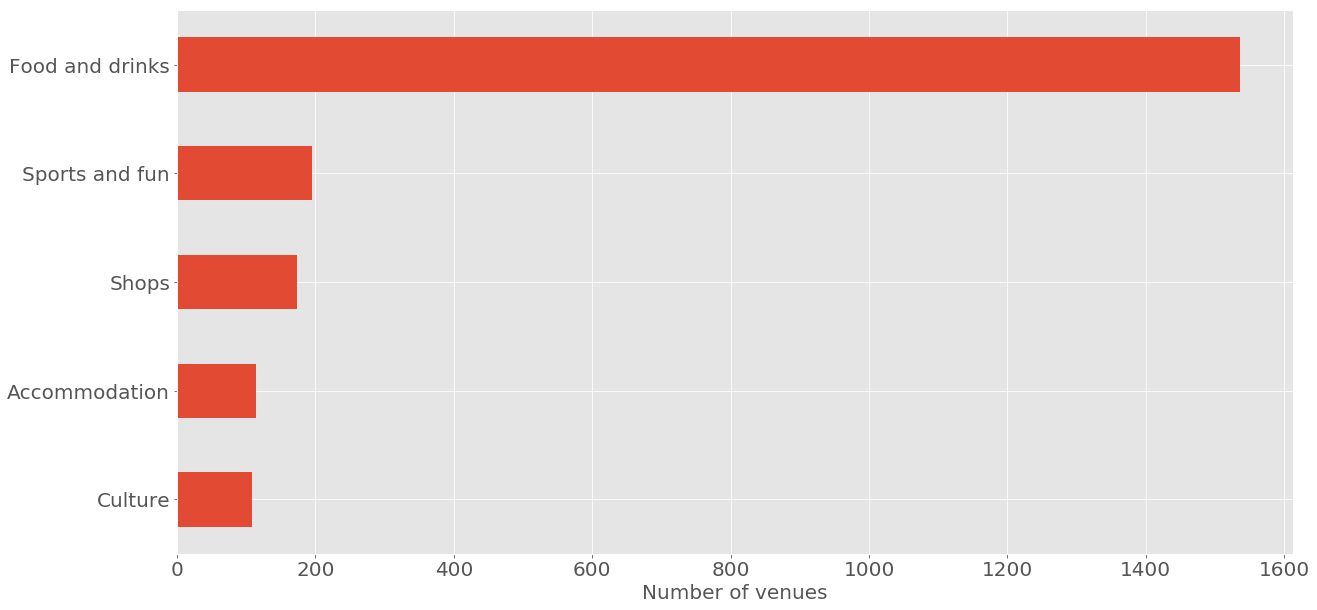

In [291]:
top_5 = pd.DataFrame(venues_df_grouped['Venue Category'].value_counts()).head(5)

fig, ax = plt.subplots(figsize = (20,10))
ax.set_xlabel('Number of venues', fontsize = 20)


top_5.plot(kind='barh', figsize = (20,10), fontsize = 20, ax = ax)
ax.set_ylabel('')
ax.get_legend().remove()

ax.invert_yaxis()

In [131]:
venues_df_grouped = venues_df_grouped[venues_df_grouped['Venue Category'].isin(venues_df_grouped['Venue Category'].value_counts()[venues_df_grouped['Venue Category'].value_counts() >= 80].index)]

In [132]:
venues_df_grouped.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,la Barceloneta,41.380894,2.189385,BRO,41.380214,2.189007,Food and drinks
3,la Barceloneta,41.380894,2.189385,La Cova Fumada,41.379254,2.189254,Food and drinks
4,la Barceloneta,41.380894,2.189385,Somorrostro,41.379156,2.189100,Food and drinks
5,la Barceloneta,41.380894,2.189385,Rumbanroll,41.380597,2.187807,Food and drinks
6,la Barceloneta,41.380894,2.189385,Mesōn Barceloneta,41.380533,2.187205,Food and drinks


In [133]:
venues_df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2126 entries, 1 to 2704
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighborhood            2126 non-null   object 
 1   Neighborhood Latitude   2126 non-null   float64
 2   Neighborhood Longitude  2126 non-null   float64
 3   Venue                   2126 non-null   object 
 4   Venue Latitude          2126 non-null   float64
 5   Venue Longitude         2126 non-null   float64
 6   Venue Category          2126 non-null   object 
dtypes: float64(4), object(3)
memory usage: 132.9+ KB


In [134]:
venues_df_grouped['Venue Category'].value_counts()

Food and drinks    1536
Sports and fun      195
Shops               173
Accommodation       114
Culture             108
Name: Venue Category, dtype: int64

Now, let us get back to our initial dataframe. We see that the 4 of the 5 categories that we have created here match with one of the top 10 that have suffered most ERTEs:

In [135]:
erte_es_grouped.head(10)

,Code,Economic sector,Number of ERTEs
50,56,Serveis de menjar i begudes,18607
43,47,"Comerç detall, exc. vehicles motor",12151
85,96,Altres activitats de serveis personals,6715
42,46,"Comerç engròs, exc. vehicles motor",5174
40,43,Activitats especialitzades construcció,4758
76,86,Activitats sanitàries,3964
41,45,Venda i reparació de vehicles motor,3537
75,85,Educació,3424
82,93,Activitats esportives i d'entreteniment,2595
49,55,Serveis d'allotjament,2354


These are, by code:
- Food and drinks = 56
- Shops = 47
- Sports and fun = 93
- Accomodation = 55

We will therefore drop the category _Culture_, since, apparently, has not suffered many ERTEs. 

In [136]:
venues_df_grouped = venues_df_grouped[(venues_df_grouped['Venue Category'] != 'Culture')]

In [137]:
venues_df_grouped['Venue Category'].value_counts()

Food and drinks    1536
Sports and fun      195
Shops               173
Accommodation       114
Name: Venue Category, dtype: int64

In [138]:
(venues_df_grouped['Venue Latitude'].astype(str) +venues_df_grouped['Venue Longitude'].astype(str))

1       41.3802138754223562.1890065281702524
3        41.379253905268662.1892540978203394
4         41.379156307676722.189099682467895
5        41.380596950092522.1878065054525377
6        41.380533297524732.1872047197081876
                        ...                 
2700       41.390911125315252.19101812813447
2701                       41.3882082.196152
2702     41.388763773617622.2004708072482533
2703     41.395558771382522.1926000109444246
2704     41.3881385473531152.195732164639047
Length: 2018, dtype: object

It is time we compute, for each of these remaining sectors, the probability that a company has suffered an ERTE, as we have explained before.

In [139]:
p_fd = erte_es_grouped[erte_es_grouped['Code'] == '56']['Number of ERTEs'].values[0]/companies_sector_cleaned[companies_sector_cleaned['Código'] == '56']['Total'].values[0]
p_s = erte_es_grouped[erte_es_grouped['Code'] == '47']['Number of ERTEs'].values[0]/companies_sector_cleaned[companies_sector_cleaned['Código'] == '47']['Total'].values[0]
p_sf = erte_es_grouped[erte_es_grouped['Code'] == '93']['Number of ERTEs'].values[0]/companies_sector_cleaned[companies_sector_cleaned['Código'] == '93']['Total'].values[0]
p_a = erte_es_grouped[erte_es_grouped['Code'] == '55']['Number of ERTEs'].values[0]/companies_sector_cleaned[companies_sector_cleaned['Código'] == '55']['Total'].values[0]

In [140]:
p_dic = {'Food and drinks':p_fd, 'Shops': p_s, 'Sports and fun': p_sf, 'Accommodation':p_a}
p_dic

{'Food and drinks': 0.4700399131005911,
 'Shops': 0.17349401030883677,
 'Sports and fun': 0.3682418050234142,
 'Accommodation': 0.5369525547445255}

Finally, by computing, for each neighborhood, the sum of the venues of a certain category, times the probability associated to that category, and suming among all categories in that neighborhood, we find the average number of business in that neighborhood that have suffered and ERTE. That will be our impact.

In [141]:
neigh_impact_df = pd.DataFrame(columns = ['Neighborhood', 'Latitude', 'Longitude', 'Impact'])
for neigh in venues_df_grouped['Neighborhood'].unique():
    lat = venues_df_grouped[venues_df_grouped['Neighborhood'] ==  neigh]['Neighborhood Latitude'].mean()
    lng = venues_df_grouped[venues_df_grouped['Neighborhood'] ==  neigh]['Neighborhood Longitude'].mean()
    impact = 0
    venues_list = venues_df_grouped[venues_df_grouped['Neighborhood'] == neigh]['Venue Category'].value_counts()
    
    for index in venues_list.index:
        impact += venues_list[index]*p_dic[index]
    
    neigh_impact_df = neigh_impact_df.append({'Neighborhood': neigh, 
                            'Latitude': lat, 
                            'Longitude': lng, 
                            'Impact': impact/len(venues_df_grouped[venues_df_grouped['Neighborhood'] == neigh]['Venue Category'])}, ignore_index = True)
        

In [142]:
neigh_impact_df

,Neighborhood,Latitude,Longitude,Impact
0,la Barceloneta,41.380894,2.189385,0.471561
1,el Gòtic,41.381905,2.178185,0.445330
2,el Raval,41.379716,2.168184,0.438454
3,"Sant Pere, Santa Caterina i la Ribera",41.386820,2.183100,0.418559
4,l'Antiga Esquerra de l'Eixample,41.388212,2.159540,0.424981
...,...,...,...,...
70,el Poblenou,41.403431,2.202795,0.454723
71,Provençals del Poblenou,41.410005,2.202992,0.451254
72,Sant Martí de Provençals,41.416578,2.197847,0.445802
73,la Verneda i la Pau,41.422229,2.204893,0.427255


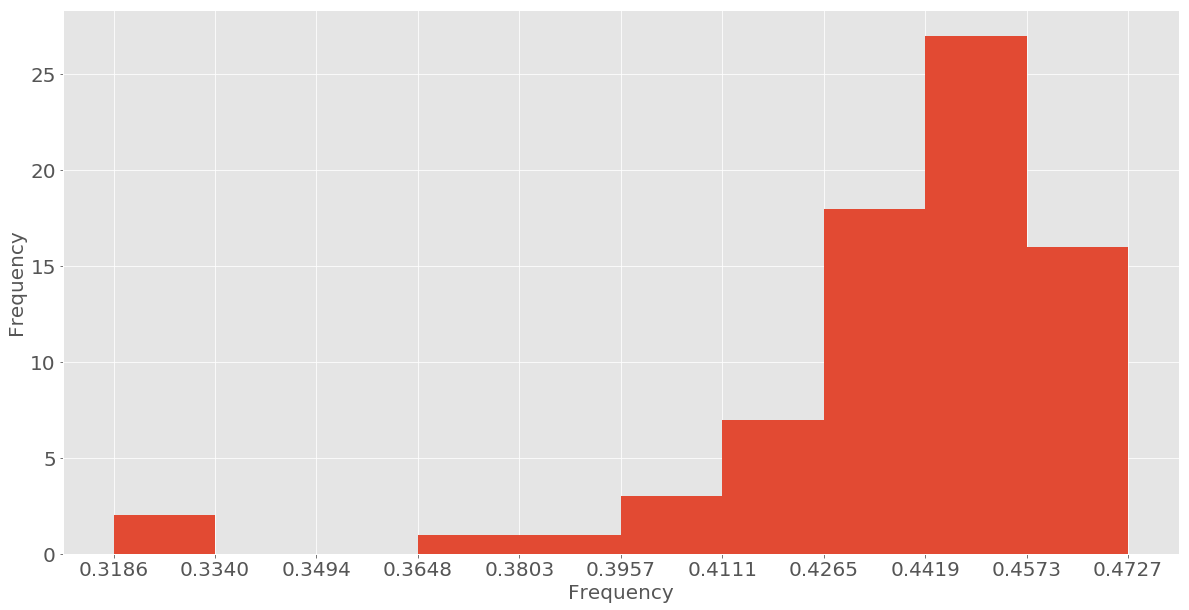

In [163]:
count, bin_edges = np.histogram(neigh_impact_df['Impact'])

fig, ax = plt.subplots(figsize = (20,10))
ax.set_xlabel('Frequency', fontsize = 20)
ax.set_ylabel('Impact', fontsize = 20)


neigh_impact_df['Impact'].plot(kind = 'hist',fontsize = 20, xticks = bin_edges, ax = ax)

As we see from the histogram, most of the neighborhoods have sufferend over 40% of ERTEs. 

### Clustering neighborhoods by impact

To simplify these results, we use kmeans, with 3 clusters, to group the neighborhoods into three categories, in terms of the impact of each neighborhood.

In [144]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(neigh_impact_df['Impact'].values.reshape(-1,1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [145]:
neigh_impact_df['Cluster'] = kmeans.labels_

In [146]:
locc1 = neigh_impact_df['Cluster'] == 0
locc2 = neigh_impact_df['Cluster'] == 1
locc3 = neigh_impact_df['Cluster'] == 2

impactc0 = neigh_impact_df[locc1]['Impact'].mean()
impactc1 = neigh_impact_df[locc2]['Impact'].mean()
impactc2 = neigh_impact_df[locc3]['Impact'].mean()

impact_means = [impactc0, impactc1, impactc2]
impact_means.sort()

neigh_impact_df.loc[locc1,'Cluster'] = impact_means.index(impactc0)
neigh_impact_df.loc[locc2,'Cluster'] = impact_means.index(impactc1)
neigh_impact_df.loc[locc3,'Cluster'] = impact_means.index(impactc2)

In [175]:
map_bcn = folium.Map(location=[latitude, longitude], zoom_start=12)

map_bcn_geo = r'barris.geojson'

map_bcn.choropleth(geo_data = map_bcn_geo, 
                   data=neigh_impact_df, 
                   columns=['Neighborhood', 'Cluster'],
                   key_on='feature.properties.NOM', 
                   fill_color='YlOrRd',
                   highlight = True)

map_bcn

In [148]:
impact_means

[0.35217924457152744, 0.4284083325676726, 0.4557737228287241]

## Conclusions

As we can see from the map, very few neighborhoods have had a low ERTE impact; that is, they have very few business that have suffered one ERTE. The vast majority of neighborhoods have experienced either a moderate impact (around 40% of business have suffered an ERTE) or a high impact (around 45%). This might be due to the fact that the most common venue category in the city, which is 'Foods and drinks', is also the one that have suffered a higher ERTE affectation. This also makes sense from the geographical point of view: most of the neighborhoods with high impact are in the center of the city and in to the coastline, which is the location of most of the bars, pubs, restaurants, and night clubs of the city. 

There are, though, some other neighborhoods in the city outskirts that also seem to have been very affected. In these neighborhoods, the most common venue category is, again, 'Foods and Drinks', but there are, in fact, very few venues of that type in them. This, combined with the fact that they are demographically and geographically different from any neighbourhood in the center, makes it unlikely that the actual ERTE affectation had been so high. Thus, this suggests that asuming a uniform probability of suffering an ERTE for each venue category across the city might not be the most precise way of tackling the problem. 